# Pretraining a deep network with shallow autoencoders

This python notebook uses Tensorflow to ilustrates how a deep network can be pre-trained. This is based on the paper:

Bengio, Yoshua, et al. "Greedy layer-wise training of deep networks." *Advances in neural information processing systems*. 2007.

Specificaly, I use **Algorithm 3** in that paper.

In [1]:
import tensorflow as tf
import numpy as np
%pylab
%matplotlib inline

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In order to test this, I use mnist:

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


You can adjust the number of steps in this cell. Here I have set it to 50,000 using full batch.
The cost is defined in this paper:

Vincent, Pascal, et al. "Extracting and composing robust features with denoising autoencoders." *Proceedings of the 25th international conference on Machine learning.* ACM, 2008.

In [3]:
NSTEPS=50000

def cost(reconstructX, trueX):
    '''
    For definition of cost see Pascal Vincent et al, 2008 equations 2 and 3
    '''
    LH = - tf.reduce_sum(trueX * tf.log(reconstructX) + (1.0-trueX) * tf.log(1.0-reconstructX), axis=1)
    return tf.reduce_mean(LH)

def PreTrainGreedyAutoEncodingDeepNet(sess, x, xdata, alpha, n=[28*28, 512, 128, 64]):
    '''
    This function pre-train weights using shallow autoenconders as described by
      Bengio et al 2007. Since this is a sequential procedure (i.e. later layers
      use previous hidden layers as input), this function not only assembles the
      graph but also runs the pre-training.
    
    sess  : session in which this network is been trained. Since this function 
            set the intial value of the weights, it is the one that calls
            global_variables_initializer
    x     : place holder for input data
    xdata : actual data for training (full batch in this implementation)
    alpha : learning rate
    n     : list of hidden layers sizes
    
    returns Wi weights, bi biases for each level i, and the output of last
      layer L. Wi and bi can be fine tuned for discrimination or deep autoencoding
    '''
    L = len(n)-1
    b = [None] * len(n)
    c = [None] * len(n)
    W = [None] * len(n)
    mu = [None] * len(n)
    theta = [None] * len(n)
    Cost = [None] * len(n)
    
    #b[0] = tf.Variable(tf.zeros([n[0]]), "b0")
    mu[0] = x
    for l in range(1,L+1):
        b[l] = tf.Variable(tf.zeros([n[l]]), name="b%d" % l)
        c[l] = tf.Variable(tf.zeros([n[l-1]]), name="c%d" % l)
        a = 1.0/n[l-1]
        W[l] = tf.Variable( tf.random_uniform([n[l-1], n[l]], -a, a) , name="W%d" % l)
        mu[l] = tf.sigmoid( tf.matmul(mu[l-1], W[l]) + b[l] )
        theta[l] = tf.sigmoid( tf.matmul(mu[l], tf.transpose(W[l])) + c[l] )
        Cost[l] = cost(theta[l], mu[l-1])
    
    sess.run(tf.global_variables_initializer())
    opt = tf.train.GradientDescentOptimizer(alpha)
    for l in range(1,L+1):
        minimize = opt.minimize(Cost[l], var_list=(W[l], b[l], c[l]))
        for i in range(NSTEPS):
            sess.run(minimize, feed_dict={x: xdata})
            
    return W[1:], b[1:], c[1:], mu[L]

In [4]:
sess = tf.Session()

In [5]:
X = tf.placeholder(tf.float32, shape=[None, 28*28], name = "X")

The next cell takes a long time to execute, even in a GPU.

In addition, the layer sizes are default [28\*28, 512, 128, 64].

In [6]:
W, b, c, mu = PreTrainGreedyAutoEncodingDeepNet(sess, X, mnist.train.images, 0.001)

I saved the weights here so that one can later use it with restart from scratch.

In [7]:
saver = tf.train.Saver(W + b + c)

In [8]:
saver.save(sess, "wbc")

'wbc'

Put the weights together, so that I can use them as a deep autoencoder

In [10]:
W2 = [tf.Variable(tf.transpose(x)) for x in W]
sess.run(tf.variables_initializer(W2))
W2.reverse()
AllW = W + W2
c.reverse()
allB = b + c

This is the deep autoencoder model. I could have fine tune it (you can even find the cost down below), but for now I just used it directly from the pre-training phase.

In [11]:
def DeepModel(X, W, B):
    res = X
    for w, b in zip(W,B):
        res = tf.sigmoid( tf.matmul(res, w) + b )
    return res

In [13]:
reconstruct = DeepModel(X, AllW, allB)

And here I am testing it with a single image.

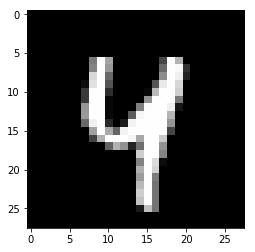

In [18]:
imshow((mnist.test.images[42]).reshape((28,28)), cmap="gray")

In [17]:
res=sess.run(reconstruct, feed_dict={X:(mnist.test.images[42]).reshape((1,28*28))})

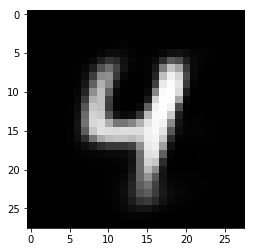

In [19]:
imshow(res.reshape((28,28)), cmap="gray")

Let us see how PCA with 64 components compare with the deep model (remember that the deep model has a 64 component size)

In [20]:
from sklearn.decomposition import PCA

In [23]:
pca = PCA(n_components=64)

In [24]:
pca.fit(mnist.train.images)

PCA(copy=True, iterated_power='auto', n_components=64, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [25]:
res = pca.inverse_transform(pca.transform(mnist.test.images[42]))

/home/erocha/opt/tensorflow/local/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


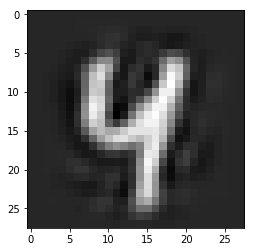

In [26]:
imshow(res.reshape((28,28)), cmap="gray")

The result is not bad. It takes much longer to train, but I didn't even fined tuned so it could have been better.

Below you see the cost that can be used to do the fine tunning.

In [ ]:
C = cosComplexWarningmplexWarningreconstruct, X)